In [1]:
import sys

import numpy as np

import argparse

import os

current_script_path = os.getcwd()
main_folder_path = os.path.dirname(current_script_path)

if main_folder_path not in sys.path:
    sys.path.append(main_folder_path)


from tqdm import tqdm 

import numpy as np
import matplotlib.pyplot as plt
import pykonal
import random

from scipy.io import loadmat

import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.animation import FuncAnimation

from scipy.ndimage import distance_transform_edt

import time

def tic():
    return time.time()

def toc(t0):
    return time.time() - t0



In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.animation import FuncAnimation

def create_obstacles(space_size, num_obstacles, min_size, max_size):
    """
    Create obstacles of different sizes in a 3D space and randomize their positions.
    
    Parameters:
    space_size (tuple): The size of the 3D space (x, y, z).
    num_obstacles (int): The number of obstacles to create.
    min_size (tuple): The minimum size of the obstacles (dx, dy, dz).
    max_size (tuple): The maximum size of the obstacles (dx, dy, dz).
    
    Returns:
    list: A list of obstacle coordinates and sizes.
    np.ndarray: A 3D mask representing the space with obstacles (0 inside obstacles, 1 in free space).
    """
    obstacles = []
    mask = np.ones(space_size, dtype=int)

    def does_intersect(new_obstacle, existing_obstacles):
        (nx, ny, nz), (ndx, ndy, ndz) = new_obstacle
        for (ex, ey, ez), (edx, edy, edz) in existing_obstacles:
            if (nx < ex + edx and nx + ndx > ex and
                ny < ey + edy and ny + ndy > ey and
                nz < ez + edz and nz + ndz > ez):
                return True
        return False

    for _ in range(num_obstacles):
        while True:
            # Randomize the size of the obstacle
            dx = random.randint(min_size[0], max_size[0])
            dy = random.randint(min_size[1], max_size[1])
            dz = random.randint(min_size[2], max_size[2])
            
            # Randomize the position of the obstacle
            x = random.randint(0, space_size[0] - dx)
            y = random.randint(0, space_size[1] - dy)
            z = random.randint(0, space_size[2] - dz)
            
            new_obstacle = ((x, y, z), (dx, dy, dz))
            
            # Check if the new obstacle intersects with any existing obstacles
            if not does_intersect(new_obstacle, obstacles):
                # Place the obstacle in the space
                mask[x:x+dx, y:y+dy, z:z+dz] = 0
                obstacles.append(new_obstacle)
                break

    return obstacles, does_intersect, mask

def plot_obstacles(space_size, obstacles, does_intersect):
    """
    Plot the obstacles in a 3D space.
    
    Parameters:
    space_size (tuple): The size of the 3D space (x, y, z).
    obstacles (list): A list of obstacle coordinates and sizes.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    def update_plot(obstacles):
        ax.cla()
        for (x, y, z), (dx, dy, dz) in obstacles:
            # Create a list of vertices for the cuboid
            vertices = [
                (x, y, z),
                (x + dx, y, z),
                (x + dx, y + dy, z),
                (x, y + dy, z),
                (x, y, z + dz),
                (x + dx, y, z + dz),
                (x + dx, y + dy, z + dz),
                (x, y + dy, z + dz)
            ]
            
            # Create a list of faces for the cuboid
            faces = [
                [vertices[0], vertices[1], vertices[2], vertices[3]],
                [vertices[4], vertices[5], vertices[6], vertices[7]],
                [vertices[0], vertices[1], vertices[5], vertices[4]],
                [vertices[2], vertices[3], vertices[7], vertices[6]],
                [vertices[1], vertices[2], vertices[6], vertices[5]],
                [vertices[4], vertices[7], vertices[3], vertices[0]]
            ]
            
            # Plot the cuboid
            ax.add_collection3d(Poly3DCollection(faces, facecolors='blue', linewidths=1, edgecolors='r', alpha=.25))
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
        ax.set_xlim([0, space_size[0]])
        ax.set_ylim([0, space_size[1]])
        ax.set_zlim([0, space_size[2]])
    
    def update_obstacles(obstacles, space_size, does_intersect):
        new_obstacles = []
        for (dx, dy, dz) in [(obs[1][0], obs[1][1], obs[1][2]) for obs in obstacles]:
            while True:
                x = random.randint(0, space_size[0] - dx)
                y = random.randint(0, space_size[1] - dy)
                z = random.randint(0, space_size[2] - dz)
                
                new_obstacle = ((x, y, z), (dx, dy, dz))
                
                if not does_intersect(new_obstacle, new_obstacles + obstacles):
                    new_obstacles.append(new_obstacle)
                    break
        return new_obstacles
    
    def animate(i):
        nonlocal obstacles
        obstacles = update_obstacles(obstacles, space_size, does_intersect)
        update_plot(obstacles)
    
    ani = FuncAnimation(fig, animate, frames=100, interval=500)
    
    plt.show()

# Example usage
space_size = (20, 20, 20)  # Size of the 3D space
num_obstacles = 10         # Number of obstacles to create
min_size = (2, 2, 2)       # Minimum size of the obstacles
max_size = (5, 5, 5)       # Maximum size of the obstacles

obstacles, does_intersect, mask = create_obstacles(space_size, num_obstacles, min_size, max_size)


In [39]:
# Number of trials
train_trial = 1
test_trial = 0

num_trials = train_trial+test_trial

goal_trials = 5
env_size = 110
count = 0

space_size = (env_size,env_size,env_size)  # Size of the 3D space
num_obstacles = 10         # Number of obstacles to create
min_size = (3, 3, 3)       # Minimum size of the obstacles
max_size = (8, 8, 8)       # Maximum size of the obstacles

x_values_array = np.zeros((env_size * env_size * env_size*1, num_trials * goal_trials))
y_values_array = np.zeros((env_size * env_size * env_size* 1, num_trials * goal_trials))
velocity_matrices_array = np.ones((num_trials * goal_trials, env_size, env_size,env_size))
travel_time_values_array = np.zeros((num_trials * goal_trials, env_size, env_size,env_size))
goals = np.zeros((num_trials * goal_trials, 3))

for trial in tqdm(range(num_trials)):
    obstacles, does_intersect, mask = create_obstacles(space_size, num_obstacles, min_size, max_size)
    original_maze = mask
    condition1 = original_maze == 1
    x_indices, y_indices, z_indices = np.indices(original_maze.shape)
    condition2 = (x_indices < env_size) & (y_indices < env_size) & (z_indices < env_size)
    combined_condition = condition1 & condition2
    dt = 0

    for goal_trial in range(goal_trials):
        passable_indices = np.argwhere(combined_condition)
        high_values_mask = None
        if passable_indices.size > 0:
            if(trial * goal_trials + goal_trial!=count):
                break
            while np.all(travel_time_values_array[trial * goal_trials + goal_trial, :, :] == 0):
                velocity_matrix = np.array(original_maze)
                goal_index = random.choice(passable_indices)
                goal = goal_index[0], goal_index[1], goal_index[2]

                # Set up the Eikonal solver
                t0 = tic()
                solver = pykonal.EikonalSolver(coord_sys="cartesian")
                solver.velocity.min_coords = 0, 0, 0
                solver.velocity.node_intervals = 1, 1, 1
                solver.velocity.npts = env_size, env_size, env_size
                solver.velocity.values = velocity_matrix.reshape(env_size, env_size, env_size)
                src_idx = goal[0], goal[1], goal_index[2]
                solver.traveltime.values[src_idx] = 0
                solver.unknown[src_idx] = False
                solver.trial.push(*src_idx)
                solver.solve()
                dt += toc(t0)

                velocity_matrices_array[trial * goal_trials + goal_trial, :, :, :] = velocity_matrix
                goals[trial * goal_trials + goal_trial,:] = goal
                travel_time_values_array[trial * goal_trials + goal_trial, :, :, :] = solver.traveltime.values[:, :, :]
                high_values_mask = solver.traveltime.values[:, :, :] > 1000
                input_mask = (velocity_matrix == 0)
                travel_time_values_array[trial * goal_trials + goal_trial, high_values_mask] = 0

            if(high_values_mask!=input_mask).any():
                velocity_matrices_array[trial * goal_trials + goal_trial, high_values_mask] = 0

            if np.any(travel_time_values_array[trial * goal_trials + goal_trial, :, :, :] > 1000):
                print("Not the right data")
                break
            if np.all(travel_time_values_array[trial * goal_trials + goal_trial, :, :, :] == 0):
                print("Not the right data")
                break
        else:
            print("Not the right data")
            break  
        count+=1 

print("Environment Size:", env_size,"Solver Took:",dt/goal_trials)

100%|██████████| 1/1 [00:04<00:00,  4.78s/it]

Environment Size: 110 Solver Took: 0.9183004856109619


Text(0.5, 1.0, 'Time Taken vs. Environment Size')

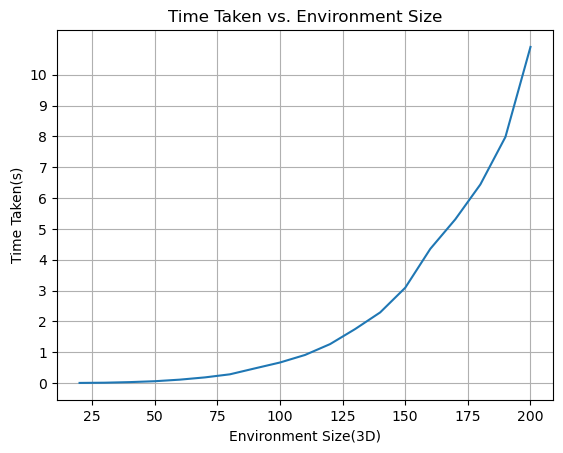

In [68]:
timetaken = np.array([0.003, 0.01, 0.029, 0.058, 0.109, 0.182, 0.282, 0.475, 0.665, 0.91, 1.262, 1.75, 2.29, 3.09, 4.35, 5.31, 6.44, 7.98, 10.9])
envsize = np.arange(20,210,10)

plt.plot(envsize,timetaken)
plt.xlabel("Environment Size")
plt.ylabel("Time Taken(s)")
plt.grid(True)
plt.yticks(range(int(min(timetaken)), int(max(timetaken)) + 1, 1))  # Adjust the range and step as needed
plt.title('Time Taken vs. Environment Size(3D)')



Text(0.5, 1.0, 'Time Taken vs. Environment Size(3D)')

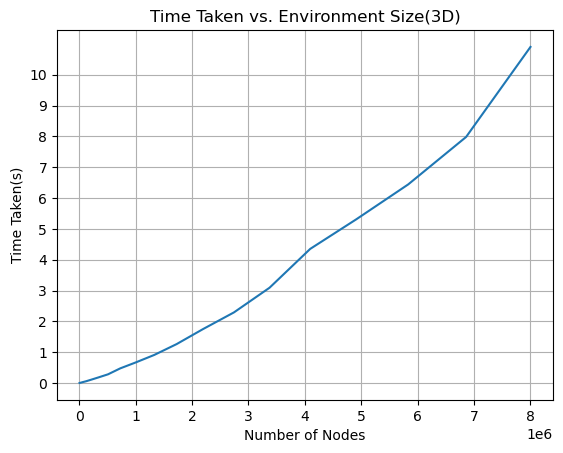

In [69]:
numofnodes = np.power(envsize, 3)


plt.plot(numofnodes,timetaken)
plt.xlabel("Number of Nodes")
plt.ylabel("Time Taken(s)")
plt.grid(True)
plt.yticks(range(int(min(timetaken)), int(max(timetaken)) + 1, 1)) 
plt.title('Time Taken vs. Environment Size(3D)')


In [4]:
np.save("3d_dataset_1/goals.npy",goals)

# Save velocity_matrices_array as "mask.npy"
np.save("3d_dataset_1/mask.npy", velocity_matrices_array)

# Save travel_time_values_array as "output.npy"
np.save("3d_dataset_1/output.npy", travel_time_values_array)

FileNotFoundError: [Errno 2] No such file or directory: '3d_dataset_1/goals.npy'

In [5]:

def calculate_signed_distance(velocity_matrix):
    # Compute the distance transform
    distance = distance_transform_edt(velocity_matrix != 0)
    return distance

signed_distance_array = np.zeros((num_trials*goal_trials, env_size, env_size, env_size))

for i in tqdm(range(0, num_trials*goal_trials)):
    signed_distance_array[i,:,:,:] = calculate_signed_distance(velocity_matrices_array[i,:,:,:])

# Save signed_distance_array as "dist_in.npy"
# np.save("3d_dataset_1/dist_in.npy", signed_distance_array)


100%|██████████| 500/500 [00:00<00:00, 844.13it/s]
